In [1]:
import re, string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)
import joblib


In [6]:
import pandas as pd

# Use the full file name with extension and set encoding
data = pd.read_csv("spam.csv", encoding="latin1")

print("Columns:", data.columns.tolist())
print(data.head())


Columns: ['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


In [7]:
# Cell 3 - auto-detect text & label columns, then standardize names
def detect_and_rename(df):
    cols = [c.lower() for c in df.columns]
    # common patterns
    text_candidates = [c for c in df.columns if any(k in c.lower() for k in ['text','message','body','email','v2','content'])]
    label_candidates = [c for c in df.columns if any(k in c.lower() for k in ['label','class','spam','v1'])]
    if 'v1' in [c.lower() for c in df.columns] and 'v2' in [c.lower() for c in df.columns]:
        df = df.rename(columns={ [c for c in df.columns if c.lower()=='v1'][0]:'label',
                                 [c for c in df.columns if c.lower()=='v2'][0]:'text' })
        return df
    if text_candidates and label_candidates:
        df = df.rename(columns={text_candidates[0]:'text', label_candidates[0]:'label'})
        return df
    raise ValueError("Couldn't auto-detect text/label columns. Columns: " + ", ".join(df.columns))

data = detect_and_rename(data)
print("Renamed to: text, label")
data[['text','label']].head()


Renamed to: text, label


,text,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


In [8]:
# Cell 4 - normalize label values to 0/1 (0=not spam, 1=spam)
def map_label_raw(x):
    s = str(x).strip().lower()
    if s in ['spam','1','true','t','yes','y','s']:
        return 1
    if s in ['ham','not spam','not_spam','0','false','f','no','n','legit','legitimate']:
        return 0
    # fallback: try numeric
    try:
        return 1 if int(s) == 1 else 0
    except:
        return 0

data['label'] = data['label'].apply(map_label_raw)
print("Label distribution:\n", data['label'].value_counts())


Label distribution:
 label
0    4825
1     747
Name: count, dtype: int64


In [ ]:
# Cell 5 - quick cleaning function (keeps things simple)
import re
def clean_text(s):
    s = str(s)
    s = s.lower()
    s = re.sub(r'http\S+|www\.\S+',' URL ', s)       # URLs
    s = re.sub(r'\d{5,}',' ZIPCODE ', s)            # long digit stretches
    s = re.sub(r'\d+',' DIGIT ', s)                 # numbers -> token
    s = re.sub(r'[\r\n]+',' ', s)
    s = re.sub(r'[^\w\s]',' ', s)                   # remove punctuation
    s = re.sub(r'\s+',' ', s).strip()
    return s

data['clean_text'] = data['text'].apply(clean_text)
data[['clean_text']].head()


In [10]:
import re

print("Available columns:", data.columns)

# Create clean_text column
def clean_text(s):
    s = str(s).lower()
    s = re.sub(r'http\S+|www\.\S+', ' URL ', s)   # replace links
    s = re.sub(r'\d+', ' DIGIT ', s)              # replace numbers
    s = re.sub(r'[^\w\s]', ' ', s)                # remove punctuation
    s = re.sub(r'\s+', ' ', s).strip()            # remove extra spaces
    return s

data['clean_text'] = data['text'].apply(clean_text)   # <-- add this line
print(data[['text','clean_text']].head())


Available columns: Index(['label', 'text', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')
                                                text  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                          clean_text  
0  go until jurong point crazy available only in ...  
1                            ok lar joking wif u oni  
2  free entry in DIGIT a wkly comp to win fa cup ...  
3        u dun say so early hor u c already then say  
4  nah i don t think he goes to usf he lives arou...  


In [11]:
# Feature extraction: Bag-of-words + handcrafted features
# Bag-of-words
vectorizer = CountVectorizer(stop_words='english', max_features=5000)  # change max_features if you like
X_bow = vectorizer.fit_transform(data['clean_text'])

# Handcrafted simple features
def handcrafted_features(series):
    df = pd.DataFrame()
    df['length'] = series.str.len()
    df['num_words'] = series.str.split().apply(lambda x: len(x) if isinstance(x, list) else 0)
    df['num_exclaims'] = series.str.count('!')
    # uppercase words in original (use raw text)
    df['num_upper_words'] = data['text'].apply(lambda s: sum(1 for w in str(s).split() if w.isupper()))
    df['num_digits'] = series.str.count(r'\d')
    df['has_url'] = series.str.contains('http|www|url').astype(int)
    df['has_free'] = series.str.contains(r'\bfree\b', case=False, regex=True).astype(int)
    return df

hand_df = handcrafted_features(data['text'])
hand_df.head()


,length,num_words,num_exclaims,num_upper_words,num_digits,has_url,has_free
0,111,20,0,0,0,0,0
1,29,6,0,0,0,0,0
2,155,28,0,2,25,0,1
3,49,11,0,2,0,0,0
4,61,13,0,1,0,0,0


In [20]:
# scale handcrafted features and combine with BoW
scaler = StandardScaler()
hand_scaled = scaler.fit_transform(hand_df)   # dense numpy array

# convert to sparse and hstack
hand_sparse = csr_matrix(hand_scaled)
X = hstack([X_bow, hand_sparse])   # final feature matrix (sparse)
y = data['label'].values

print("Final feature shape:", X.shape)


Final feature shape: (5572, 5007)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (4457, 5007) Test size: (1115, 5007)


In [15]:
model = LogisticRegression(max_iter=1000, solver='liblinear')  # solver ok for small/medium
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000, solver='liblinear')

In [16]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc = roc_auc_score(y_test, y_proba)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1-score:", f1)
print("ROC AUC:", roc)
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))


Accuracy: 0.9883408071748879
Precision: 0.9927536231884058
Recall: 0.9194630872483222
F1-score: 0.9547038327526133
ROC AUC: 0.9957133130462573

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       966
           1       0.99      0.92      0.95       149

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



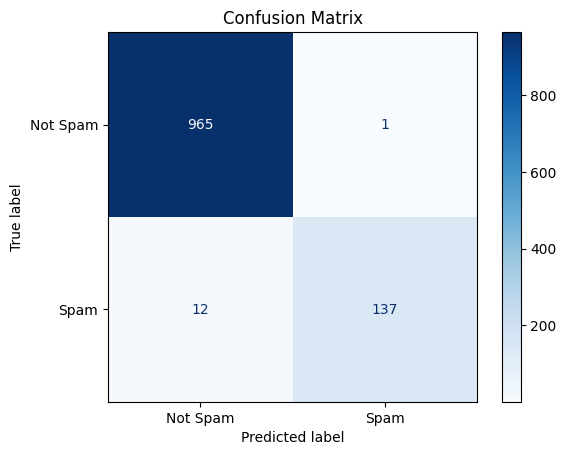

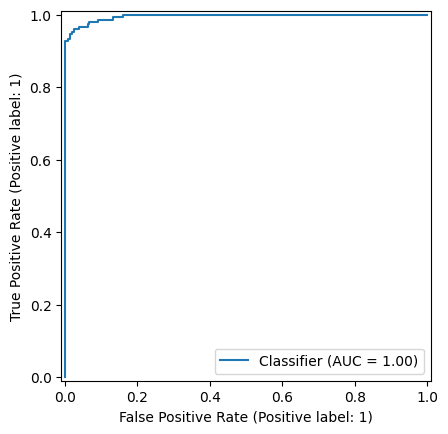

In [17]:
# Confusion Matrix plot + ROC curve
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Spam','Spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.show()


In [18]:
# Inspect top features (most spammy / most hammy)
feature_names = list(vectorizer.get_feature_names_out()) + list(hand_df.columns)
coefs = model.coef_[0]
# get top positive (spam) and negative (ham) coefficients
top_spam_idx = np.argsort(coefs)[-15:][::-1]
top_ham_idx = np.argsort(coefs)[:15]

print("Top spam indicators:")
for i in top_spam_idx:
    print(feature_names[i], round(coefs[i],4))

print("\nTop ham indicators:")
for i in top_ham_idx:
    print(feature_names[i], round(coefs[i],4))


Top spam indicators:
num_digits 4.0124
ringtone 1.522
mobile 1.4304
sms 1.3294
reply 1.3137
uk 1.2993
enjoy 1.2672
text 1.246
service 1.2146
length 1.1858
new 1.1278
txt 1.1072
order 1.0196
brought 0.9249
won 0.9172

Top ham indicators:
gt -1.1341
lt -1.122
ubi -1.0474
got -0.9862
say -0.7208
place -0.7053
ll -0.7051
people -0.6903
hey -0.685
sorry -0.6786
know -0.6548
num_words -0.6394
later -0.6204
ard -0.6179
ì_ -0.6153


In [19]:
# Save model and processors (vectorizer + scaler + column names)
joblib.dump(model, "spam_logreg_model.joblib")
joblib.dump(vectorizer, "vectorizer.joblib")
joblib.dump(scaler, "scaler.joblib")
joblib.dump(hand_df.columns.tolist(), "hand_columns.joblib")
print("Saved model and transformers.")


Saved model and transformers.
